In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [45]:
# downloading data
start_date = '2013-01-01'
end_date = '2023-06-05'
data = yf.download(tickers="RELIANCE.NS",start=start_date,end=end_date,period='1d')
array = data['Close'].to_numpy()
dates = data.index

[*********************100%***********************]  1 of 1 completed


In [46]:
time_steps = 80
len_array = len(array)
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(array.reshape(-1,1))

In [47]:
n = int(np.round(len_array*0.05))
train = scaled_array[:-n]
test = scaled_array[-n:]
dates_train = dates[:-n]
dates_test = dates[-n:]
print('train length is',len(train),', test length is',len(test))

dates_train = dates_train[time_steps+1:]
dates_test = dates_test[time_steps+1:]
print('dates train length is',len(dates_train),', dates test length is',len(dates_test))

train length is 2442 , test length is 129
dates train length is 2361 , dates test length is 48


In [48]:
def process_data(data_array):
  y_data = data_array[time_steps+1:]
  x_data = np.concatenate([data_array[j:len(data_array)+j-1-time_steps] for j in range(time_steps+1)],axis=1)
  x_data = x_data.reshape((len(data_array)-time_steps-1,time_steps+1,1))
  #print('xdata shape is',x_data.shape,', ydata length is',len(y_data))
  return x_data, y_data

x_train, y_train = process_data(train)
x_test, y_test = process_data(test)

In [49]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps+1,1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
    ])
model.compile(loss='mean_squared_error',optimizer='adam')
print(model.summary())

history = model.fit(x_train,y_train,epochs=5,batch_size=128)

y_pred = model.predict(x_test)
unscaled_y_pred = scaler.inverse_transform(y_pred)
unscaled_y_test = scaler.inverse_transform(y_test)
print('RMSE on test data',mean_squared_error(unscaled_y_test,unscaled_y_pred))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 81, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 81, 50)            20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
19/19 [==============================] - 12s 68ms/step - loss: 0.0302
Epoch 2/5
19/19 [==============================] - 1s 67ms/step - loss: 0.0026
Epoch 3/5
19/19 [=

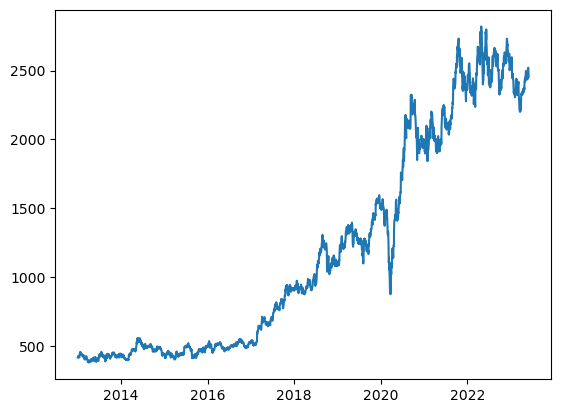

In [50]:

def predict_future(n_steps):
  pred_dates = pd.bdate_range(start=dates[-1],periods=n_steps)
  array = scaled_array[-(time_steps+2):] 
  pred_stocks = np.empty(n_steps) # initial empty list
  for i in range(n_steps):
    x,y = process_data(array)
    y_pred = model.predict(x)
    y_pred_unscaled = scaler.inverse_transform(y_pred.reshape(1,-1)) #[[value]]
    pred_stocks[i] = y_pred_unscaled.flatten()
    array = np.append(array,y_pred,axis=0)
    array = array[1:]
  return pred_stocks, pred_dates

fig1,ax1 = plt.subplots()
ax1.plot(dates,array)

## model in different function

In [2]:
def load_train_data(start_date, end_date,time_steps):
    data = yf.download(tickers="RELIANCE.NS",start=start_date,end=end_date,period='1d')
    array = data['Close'].to_numpy()
    dates = data.index
    len_array = len(array)
    scaler = MinMaxScaler()
    scaled_array = scaler.fit_transform(array.reshape(-1,1))
    n = int(np.round(len_array*0.25))
    train = scaled_array[:-n]
    test = scaled_array[-n:]
    dates_train = dates[:-n]
    dates_test = dates[-n:]
    #print('train length is',len(train),', test length is',len(test))
    dates_train = dates_train[time_steps+1:]
    dates_test = dates_test[time_steps+1:]
    #print('dates train length is',len(dates_train),', dates test length is',len(dates_test))
    return dates_train, dates_test, train, test, scaled_array,dates, scaler,array

dates_train, dates_test, train, test, scaled_array,dates,scaler,array = load_train_data('2013-01-01','2023-06-05',80)

[*********************100%***********************]  1 of 1 completed


In [3]:
def process_data(data_array,time_steps):
  y_data = data_array[time_steps+1:]
  x_data = np.concatenate([data_array[j:len(data_array)+j-1-time_steps] for j in range(time_steps+1)],axis=1)
  x_data = x_data.reshape((len(data_array)-time_steps-1,time_steps+1,1))
  #print('xdata shape is',x_data.shape,', ydata length is',len(y_data))
  return x_data, y_data

x_train, y_train = process_data(train,80)
x_test, y_test = process_data(test,80)

In [4]:
def train_model(time_steps):
    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps+1,1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
    ])
    model.compile(loss='mean_squared_error',optimizer='adam')
    #print(model.summary())
    history = model.fit(x_train,y_train,epochs=5,batch_size=128)
    y_pred = model.predict(x_test)
    #unscaled_y_pred = scaler.inverse_transform(y_pred)
    #unscaled_y_test = scaler.inverse_transform(y_test)
    #rmse_error = mean_squared_error(unscaled_y_test,unscaled_y_pred)
    #print('RMSE on test data',rmse_error)
    return model

model = train_model(80)

Epoch 1/5
15/15 [==============================] - 13s 79ms/step - loss: 0.0190
Epoch 2/5
15/15 [==============================] - 1s 65ms/step - loss: 0.0028
Epoch 3/5
15/15 [==============================] - 1s 63ms/step - loss: 9.9591e-04
Epoch 4/5
15/15 [==============================] - 1s 63ms/step - loss: 6.4496e-04
Epoch 5/5
18/18 [==============================] - 4s 32ms/step


In [5]:

def predict_future(n_steps,time_steps):
  pred_dates = pd.bdate_range(start=dates[-1],periods=n_steps)
  array = scaled_array[-(time_steps+2):] 
  pred_stocks = np.empty(n_steps) # initial empty list
  for i in range(n_steps):
    x,y = process_data(array,time_steps)
    y_pred = model.predict(x)
    y_pred_unscaled = scaler.inverse_transform(y_pred.reshape(1,-1)) #[[value]]
    pred_stocks[i] = y_pred_unscaled.flatten()
    array = np.append(array,y_pred,axis=0)
    array = array[1:]
  return pred_stocks, pred_dates

pred_stocks, pred_dates = predict_future(30,80)

1/1 [==============================] - 0s 126ms/step


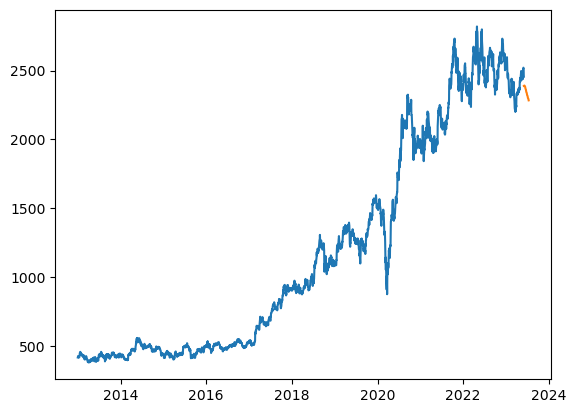

In [6]:
fig1,ax1 = plt.subplots()
ax1.plot(dates,array)
ax1.plot(pred_dates,pred_stocks)